In [168]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import os

# Importing SSN & F10.7 prediction sets

- ssn: mean monthly S.I.D.C. sunspot number
- f10.7: mean monthly Penticton, B.C. 10.7cm radio flux values (sfu)

In [169]:
# Importing forecast datasets :

prophet_ssn = pd.read_csv('../data/prophet_10Y_ssn_forecast.csv') 
sarima_ssn = pd.read_csv('../data/sarima_10Y_ssn_forecast.csv')
prophet_f10_7 = pd.read_csv('../data/prophet_10Y__f10_7_forecast.csv')

In [170]:
#checking length as prophet is missing the last month of prediction(i'll cut sarima's last month off, to get comparable )
print(prophet_ssn.shape)
print('----------')
print(sarima_ssn.shape)
print('----------')
print(prophet_f10_7.shape)

(119, 2)
----------
(120, 2)
----------
(119, 2)


In [171]:
print(prophet_ssn.head(3))
print('------')
print(sarima_ssn.head(3))
print('------')
print(prophet_f10_7.head(3))
print('------')

           ds  prophet_ssn
0  2024-01-01    34.632680
1  2024-02-01    92.861541
2  2024-03-01    67.360377
------
           ds  sarima_ssn
0  2024-01-01  112.628113
1  2024-02-01  115.217627
2  2024-03-01  119.797781
------
           ds  prophet_f10_7
0  2024-01-01     153.804489
1  2024-02-01     358.812411
2  2024-03-01     258.078365
------


# Comparing with NOAA's prediction

The forecast comes from the Solar Cycle Prediction Panel representing NOAA, NASA and the International Space Environmental Services (ISES) which was convened in 2019. 
This amounts to the official forecast for the solar cycle 25. After an open solicitation, the Panel received nearly 50 distinct forecasts for Solar Cycle 25 
from the scientific community. Prediction methods include a variety of physical models, precursor methods, statistical inference, machine learning, 
and other techniques. The prediction released by the panel is a synthesis of these community contributions.
The Prediction Panel predicted Cycle 25 to reach a maximum of 115 occurring in July, 2025. 

Access the prediction method :
https://testbed.swpc.noaa.gov/products/solar-cycle-progression-updated-prediction-experimental

In [172]:
noaa_prediction = pd.read_csv('../data/noaa_prediction.csv') 

columns_to_drop = ['high_ssn', 'low_ssn', 'high_f10.7', 'low_f10.7']
noaa_prediction = noaa_prediction.drop(columns=columns_to_drop)

noaa_prediction = noaa_prediction.rename(columns={'time_tag': 'ds', 'predicted_ssn': 'noaa_ssn', 'predicted_f10.7':'noaa_f10_7'})

noaa_prediction


,ds,noaa_ssn,noaa_f10_7
0,2023-07-01,123.2,157.40
1,2023-08-01,120.6,152.90
2,2023-09-01,119.0,149.50
3,2023-10-01,118.2,147.30
4,2023-11-01,116.9,145.20
...,...,...,...
205,2040-08-01,0.0,67.73
206,2040-09-01,0.0,67.73
207,2040-10-01,0.0,67.73
208,2040-11-01,0.0,67.73


In [173]:
# Merge dataframes on the 'ds' column
merged_df = pd.merge(noaa_prediction, prophet_ssn, on='ds', how='outer', suffixes=('_noaa', '_prophet_ssn'))
merged_df = pd.merge(merged_df, sarima_ssn, on='ds', how='outer', suffixes=('_prophet_ssn', '_sarima'))
merged_df = pd.merge(merged_df, prophet_f10_7, on='ds', how='outer', suffixes=('_sarima', '_prophet_f10_7'))

#drop any rows containing NANs
merged_df = merged_df.dropna()

print(merged_df.tail(20))

             ds  noaa_ssn  noaa_f10_7  prophet_ssn  sarima_ssn  prophet_f10_7
105  2032-04-01       7.4        70.5    10.585566   52.561113     111.744621
106  2032-05-01       6.9        70.3     8.080993   44.787101     157.429360
107  2032-06-01       6.5        70.1    11.919604   65.142003      96.656488
108  2032-07-01       6.1        70.0    10.801935   53.735263     145.245032
109  2032-08-01       5.7        69.8    14.747409   55.011069     182.821360
110  2032-09-01       5.3        69.7    15.926187   77.148969     169.439217
111  2032-10-01       5.0        69.5    17.042012   70.798295     181.542941
112  2032-11-01       4.7        69.4    10.983706   69.087270     165.347971
113  2032-12-01       4.4        69.3    13.784591   82.881910     113.821697
114  2033-01-01       4.1        69.2    10.140382   84.172952     132.125577
115  2033-02-01       3.8        69.1    27.524469   92.493921     306.115638
116  2033-03-01       3.5        69.0    20.999223   76.065070  

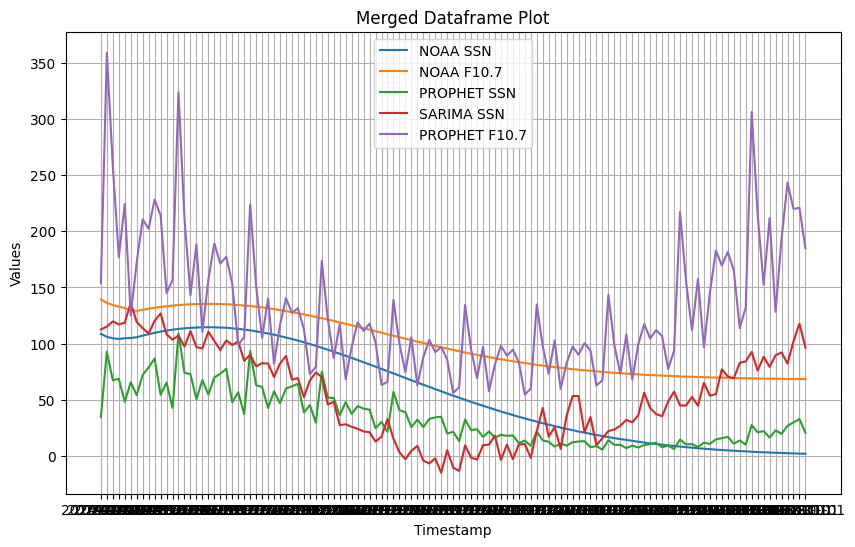

In [174]:
plt.figure(figsize=(10, 6))
plt.plot(merged_df['ds'], merged_df['noaa_ssn'], label='NOAA SSN')
plt.plot(merged_df['ds'], merged_df['noaa_f10_7'], label='NOAA F10.7')
plt.plot(merged_df['ds'], merged_df['prophet_ssn'], label='PROPHET SSN')
plt.plot(merged_df['ds'], merged_df['sarima_ssn'], label='SARIMA SSN')
plt.plot(merged_df['ds'], merged_df['prophet_f10_7'], label='PROPHET F10.7')

# Adding labels and title
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.title('Merged Dataframe Plot')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Generating a full historical + forecast vision

In [175]:
historical_data = pd.read_csv('../data/solar_cycle.csv') 
columns_to_drop = ['smoothed_ssn', 'observed_swpc_ssn', 'smoothed_swpc_ssn', 'smoothed_f10.7']
historical_data = historical_data.drop(columns=columns_to_drop)


In [180]:
import plotly.graph_objects as go

#increasing by 25% the prophet_ssn to get closer to prediction historical starting point
merged_df['prophet_ssn'] = merged_df['prophet_ssn'] * 1.25


# Plotting the historical data
fig = go.Figure()

fig.add_trace(go.Scatter(x=historical_data['time_tag'], y=historical_data['ssn'], mode='lines', name='Historical SSN', line=dict(dash='dash')))
fig.add_trace(go.Scatter(x=historical_data['time_tag'], y=historical_data['f10.7'], mode='lines', name='Historical F10.7', line=dict(dash='dash')))

# Plotting the smoothed forecasted data
fig.add_trace(go.Scatter(x=merged_df['ds'], y=merged_df['noaa_ssn'], mode='lines', name='NOAA SSN Forecast'))
fig.add_trace(go.Scatter(x=merged_df['ds'], y=merged_df['noaa_f10_7'], mode='lines', name='NOAA F10.7 Forecast'))
fig.add_trace(go.Scatter(x=merged_df['ds'], y=merged_df['prophet_ssn'], mode='lines', name='PROPHET SSN'))
fig.add_trace(go.Scatter(x=merged_df['ds'], y=merged_df['sarima_ssn'], mode='lines', name='SARIMA SSN'))
fig.add_trace(go.Scatter(x=merged_df['ds'], y=merged_df['prophet_f10_7'], mode='lines', name='PROPHET F10.7'))

# Adding layout 
fig.update_layout(
    xaxis=dict(title='Timestamp', rangeselector=dict(buttons=list([dict(count=1, label='1m', step='month', stepmode='backward'),
                                                                   dict(count=6, label='6m', step='month', stepmode='backward'),
                                                                   dict(count=1, label='YTD', step='year', stepmode='todate'),
                                                                   dict(count=1, label='1y', step='year', stepmode='backward'),
                                                                   dict(step='all')])),
                 rangeslider=dict(visible=True)),
    yaxis=dict(title='Values'),
    title='Merged Dataframe Plot',
    showlegend=True,
    template='plotly_dark'
)

# Show the plot
fig.show()


In [178]:
import functions as fun
classified_data = fun.classify_sfu_data(merged_df.copy(), 'prophet_f10_7')

classified_data['prophet_f10_7_class'].value_counts()

prophet_f10_7_class
A    119
Name: count, dtype: int64

# Smoothering data to have a clearer view of the forecast trends

In [181]:
import plotly.graph_objects as go


#smoothering data to show trend and closeness to the NOAA's predictions, can be deactivated/commented to see real data

window_size = 5
merged_df['prophet_f10_7'] = merged_df['prophet_f10_7'].rolling(window=window_size).mean()
merged_df['prophet_ssn'] = merged_df['prophet_ssn'].rolling(window=window_size).mean()
merged_df['sarima_ssn'] = merged_df['sarima_ssn'].rolling(window=window_size).mean()

# Plotting the historical data
fig = go.Figure()

fig.add_trace(go.Scatter(x=historical_data['time_tag'], y=historical_data['ssn'], mode='lines', name='Historical SSN', line=dict(dash='dash')))
fig.add_trace(go.Scatter(x=historical_data['time_tag'], y=historical_data['f10.7'], mode='lines', name='Historical F10.7', line=dict(dash='dash')))

# Plotting the smoothed forecasted data
fig.add_trace(go.Scatter(x=merged_df['ds'], y=merged_df['noaa_ssn'], mode='lines', name='NOAA SSN Forecast'))
fig.add_trace(go.Scatter(x=merged_df['ds'], y=merged_df['noaa_f10_7'], mode='lines', name='NOAA F10.7 Forecast'))
fig.add_trace(go.Scatter(x=merged_df['ds'], y=merged_df['prophet_ssn'], mode='lines', name='Anthony - PROPHET SSN'))
fig.add_trace(go.Scatter(x=merged_df['ds'], y=merged_df['sarima_ssn'], mode='lines', name='Anthony - SARIMA SSN'))
fig.add_trace(go.Scatter(x=merged_df['ds'], y=merged_df['prophet_f10_7'], mode='lines', name='Anthony - PROPHET F10.7'))

# Adding layout 
fig.update_layout(
    xaxis=dict(title='Timestamp', rangeselector=dict(buttons=list([dict(count=1, label='1m', step='month', stepmode='backward'),
                                                                   dict(count=6, label='6m', step='month', stepmode='backward'),
                                                                   dict(count=1, label='YTD', step='year', stepmode='todate'),
                                                                   dict(count=1, label='1y', step='year', stepmode='backward'),
                                                                   dict(step='all')])),
                 rangeslider=dict(visible=True)),
    yaxis=dict(title='Values'),
    title='Merged Dataframe Plot',
    showlegend=True,
    template='plotly_dark'
)

# Show the plot
fig.show()


# Checking level of classification based on F10.7 emissions

In [179]:
import functions as fun
classified_data = fun.classify_sfu_data(merged_df.copy(), 'prophet_f10_7')

classified_data['prophet_f10_7_class'].value_counts()

prophet_f10_7_class
A    119
Name: count, dtype: int64